Datacamp LDA example from:

https://campus.datacamp.com/courses/fraud-detection-in-python/fraud-detection-using-text?ex=8

LDA yields 2 Dirichlet distributions:
1. Topics per text item (probabilities)
2. Words per topic

Implementation
1. Load the train dataset created in 00_load_data
3. Tokenize. Dictionary: which words appear how often in all of the text, Corpus: for each text line, the count of words that appear.
4. Fit the LDA model on the train data, save it


In [1]:
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import preprocess_string
import pandas as pd
from matplotlib import pyplot as plt 

%matplotlib inline

In [2]:
%%time

arxiv_nlp = pd.read_csv('../data/arxiv_nlp_train.csv.zip', index_col=0)

CPU times: user 298 ms, sys: 20.4 ms, total: 319 ms
Wall time: 319 ms


## Tokenize

Apply default pre-processing filters:
strip_tags, strip_punctuation, strip_multiple_whitespaces, stric_numeric, remove_stopwords; strip_short, stem_text

see: https://github.com/piskvorky/gensim/blob/develop/gensim/parsing/preprocessing.py

In [3]:
def clean(abstracts):
    texts = [
        preprocess_string(text)
        for text in abstracts
    ]
    return texts

texts = clean(arxiv_nlp['abstract'])

In [4]:
def dict_corpus(texts):
    # Dictionary of the number of times a word appears in all of the text
    dictionary = corpora.Dictionary(texts)
    # Filter out uncommon words, keep the most common words
    dictionary.filter_extremes(no_below=5, keep_n=50000)
    # Corpus uses the bag-of-words format (bow), i.e. each row in the data is a list of words with their associated word counts.
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

dictionary, corpus = dict_corpus(texts)

## Fit the LDA model
Fit the model on the training set, for different values of k.

Validate the model by computing perplexity for different values of k. The best value for k is that which yields a perplexity closest to 0.

Since LDA has a random component, the best k might vary between runs. Therefore the model is fitted several times and the best value is compiled from all runs (mode of best k for all runs).

see: https://radimrehurek.com/gensim/models/ldamodel.html

In [5]:
%%time

min_k = 2
max_k = 12
max_runs = 5
perplexity = []
for run in range(max_runs):
    print(f"Run {run + 1} / {max_runs}")
    px = []
    num_topics = []
    for k in range(min_k, max_k + min_k):
        # Define the LDA model
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word=dictionary, passes=15)
        num_topics.append(k)
        px.append(ldamodel.log_perplexity(corpus))
    perplexity.append(pd.DataFrame.from_dict({'k': num_topics, 'val': px}))

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 1h 22min 44s, sys: 376 ms, total: 1h 22min 45s
Wall time: 1h 22min 45s


The "log_perlexity" function returns the per-word likelihood _bound_. The _perplexity_ itself can be computed by

$$perplexity = 2^{-bound}$$


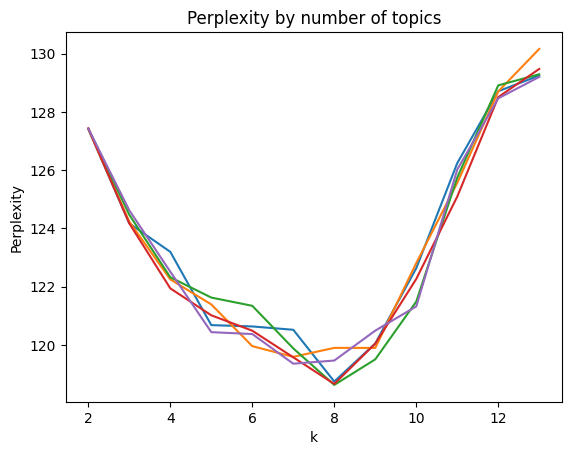

In [6]:
for run in range(max_runs):
    plt.plot(perplexity[run].k, 2**(-perplexity[run].val))
plt.title("Perplexity by number of topics")
plt.xlabel("k")
plt.ylabel("Perplexity")
plt.show()

### Find the best k value: mode of list of best values for each run

In [7]:
import statistics

best_k_runs = []
for run in range(max_runs):
    best_k_runs.append(perplexity[run].sort_values('val', ascending=False).iloc[0]['k'])
best_k = statistics.mode(best_k_runs)
print(f"Best number of topics after {max_runs} runs is: {best_k}")

Best number of topics after 5 runs is: 8.0


## Refit the model, with best k

In [8]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=best_k, id2word=dictionary, passes=15)

Print the topics, with top words

In [9]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.035*"word" + 0.016*"embed" + 0.015*"semant" + 0.013*"sentenc" + 0.011*"represent"')
(1, '0.033*"gener" + 0.020*"question" + 0.018*"llm" + 0.016*"answer" + 0.016*"task"')
(2, '0.038*"data" + 0.033*"train" + 0.025*"learn" + 0.019*"label" + 0.019*"task"')
(3, '0.020*"inform" + 0.018*"entiti" + 0.018*"extract" + 0.018*"knowledg" + 0.017*"propos"')
(4, '0.035*"translat" + 0.032*"speech" + 0.015*"neural" + 0.013*"propos" + 0.012*"recognit"')
(5, '0.032*"train" + 0.027*"task" + 0.018*"perform" + 0.015*"pre" + 0.015*"tune"')
(6, '0.016*"user" + 0.013*"dialogu" + 0.011*"convers" + 0.011*"human" + 0.008*"research"')
(7, '0.017*"dataset" + 0.014*"detect" + 0.014*"text" + 0.013*"new" + 0.012*"sentiment"')


## Save the model

In [10]:
import pickle

with open('../models/lda_nlp_train.pickle', 'wb') as handle:
    pickle.dump(ldamodel, handle, protocol=pickle.HIGHEST_PROTOCOL)